# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 7
# LDA/QDA and Decision Trees

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): **Chia Chi Ho (Michelle Ho)**

Enrollment Status (109A, 121A, 209A, or E109A): **209A**

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `hw7_dataset.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI machine learning repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the following code:

In [2]:
np.random.seed(9001)
df = pd.read_csv('hw7_dataset.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

## Question 1: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the training and test sets?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
    <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

> ### 2D scatter plot of the training set

In [3]:
# Split TRAIN & TEST data into predictors(X) and response(y)
X_train = data_train.iloc[:, :-1]
X_test = data_test.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
y_test = data_test.iloc[:, -1]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((102, 2), (113, 2), (102,), (113,))

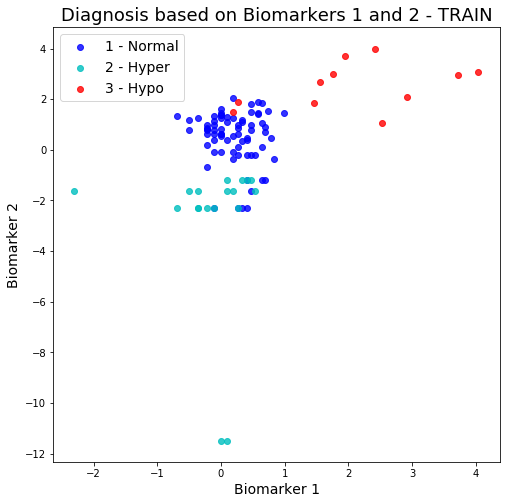

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

ax.scatter(X_train[y_train == 1].iloc[:, 0], X_train[y_train == 1].iloc[:, 1], color='b', 
           alpha=0.8, label='1 - Normal')
ax.scatter(X_train[y_train == 2].iloc[:, 0], X_train[y_train == 2].iloc[:, 1], color='c', 
           alpha=0.8, label='2 - Hyper')
ax.scatter(X_train[y_train == 3].iloc[:, 0], X_train[y_train == 3].iloc[:, 1], color='r', 
           alpha=0.8, label='3 - Hypo')

ax.set_xlabel("Biomarker 1", fontsize=14)
ax.set_ylabel("Biomarker 2", fontsize=14)
ax.set_title("Diagnosis based on Biomarkers 1 and 2 - TRAIN", fontsize=18)
ax.legend(fontsize=14)

> ### Multinomial & OvR logistic regression

In [5]:
log_multi = LogisticRegressionCV(penalty='l2', multi_class='multinomial').fit(X_train, y_train)
print('=============================')
print("MULTINOMIAL logistic regression\n")
print('Optimal C = {}'.format(log_multi.C_))
print('train_acc = {}\ntest_acc = {}\n'.format(log_multi.score(X_train, y_train), log_multi.score(X_test, y_test)))

log_ovr = LogisticRegressionCV(penalty='l2', multi_class='ovr').fit(X_train, y_train)
print('=============================')
print("ONE-VS-REST logistic regression\n")
print('Optimal C = {}'.format(log_ovr.C_))
print('train_acc = {}\ntest_acc = {}\n'.format(log_ovr.score(X_train, y_train), log_ovr.score(X_test, y_test)))


MULTINOMIAL logistic regression

Optimal C = [ 2.7825594  2.7825594  2.7825594]
train_acc = 0.8921568627450981
test_acc = 0.8849557522123894

ONE-VS-REST logistic regression

Optimal C = [ 0.35938137  2.7825594   2.7825594 ]
train_acc = 0.8431372549019608
test_acc = 0.8407079646017699



> ### Multiclass Logistic Regression with quadratic terms 
> Both Multinomial & OvR implemented for reference.

In [6]:
# Generate quadratic terms
X_train_quad = PolynomialFeatures(2).fit_transform(X_train)
X_test_quad = PolynomialFeatures(2).fit_transform(X_test)

y_train.shape, X_train_quad.shape, y_test.shape, X_test_quad.shape

((102,), (102, 6), (113,), (113, 6))

In [7]:
# Fit and score Multi-class LogisticRegression with quadratic terms
log_multi_quad = LogisticRegressionCV(penalty='l2', multi_class='multinomial').fit(X_train_quad, y_train)
print('=============================')
print('MULTINOMIAL logistic regression w/ QUADRATIC TERMS\n')
print('Optimal C = {}'.format(log_multi_quad.C_))
print('train_acc = {}\ntest_acc = {}\n'.format(log_multi_quad.score(X_train_quad, y_train), log_multi_quad.score(X_test_quad, y_test)))

log_ovr_quad = LogisticRegressionCV(penalty='l2', multi_class='ovr').fit(X_train_quad, y_train)
print('=============================')
print('ONE-VS-REST logistic regression w/ QUADRATIC TERMS\n')
print('Optimal C = {}'.format(log_ovr_quad.C_))
print('train_acc = {}\ntest_acc = {}\n'.format(log_ovr_quad.score(X_train_quad, y_train), log_ovr_quad.score(X_test_quad, y_test)))


MULTINOMIAL logistic regression w/ QUADRATIC TERMS

Optimal C = [ 2.7825594  2.7825594  2.7825594]
train_acc = 0.8921568627450981
test_acc = 0.8938053097345132

ONE-VS-REST logistic regression w/ QUADRATIC TERMS

Optimal C = [ 21.5443469    2.7825594    0.35938137]
train_acc = 0.8823529411764706
test_acc = 0.8761061946902655



> ### Linear Discriminant Analysis

In [8]:
# Fit and score LDA
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
print('=============================')
print('LDA\n')
print('train_acc = {}\ntest_acc = {}\n'.format(lda.score(X_train, y_train), lda.score(X_test, y_test)))

LDA

train_acc = 0.8725490196078431
test_acc = 0.831858407079646



> ### Quadratic Discriminant Analysis 

In [9]:
# Fit and score QDA
qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
print('=============================')
print('QDA\n')
print('train_acc = {}\ntest_acc = {}\n'.format(qda.score(X_train, y_train), qda.score(X_test, y_test)))

QDA

train_acc = 0.8725490196078431
test_acc = 0.8495575221238938



> ### k-Nearest Neighbors

In [10]:
# Fit and score KNN using CV to find the Optimal K
ks = [1, 2, 3, 5, 7, 10, 20, 30]

cv_scores = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = ks[cv_scores.index(max(cv_scores))]
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k).fit(X_train, y_train)
print('=============================')
print('KNN Classifier\n')
print('Optimal K = {}'.format(optimal_k))
print('train_acc = {}\ntest_acc = {}\n'.format(knn_optimal.score(X_train, y_train), knn_optimal.score(X_test, y_test)))

KNN Classifier

Optimal K = 3
train_acc = 0.9313725490196079
test_acc = 0.8672566371681416



## Answers for Questions 1

Does it appear that the data points can be separated well by a linear classifier?

> **Yes. The scatter plot shows that the data points can be separately relatively well (but not perfectly) by a linear boundaries. Thus, they can be seperated by a linear classifier.**

Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

> **One-vs-Rest (OvR) logistic regression fits each class against the rest classes, giving `k` probabilities where `k` is the number of classes. It classifies an observation as the class associated with the highest fitted probability. In this way, the fitted probabilities of all classes do not necessarily add up to 1, and thus can be sensitive to outliers.**

> **On the other hand, multinomial logistic regression learns the parameters for each class interdependently and draws its decision boundaries only once. In this way, the fitted probabilities of the classes add up to 1 at any given point, and thus can be more robust to outliers.**

Is there a difference in the overall classification accuracy of the two methods on the training and test sets?

> **Yes, there is. Multinomial logsitic regression performed better than OvR on both the training and the test sets. The overall classification accuracies are reprinted below:**

>> ** Multinomial TRAINING accuracy: 0.8921568627450981**

>> ** OvR TRAINING accuracy: 0.8431372549019608**

>> ** Multinomial TEST accuracy: 0.8849557522123894**

>> ** OvR TEST accuracy: 0.8407079646017699**


Compare the training and test accuracies of these models with the following classification methods:

 **Classifier**                |    **Training accuracy**     |     **Test accuracy**
-------------------------------|------------------------------|------------------------
Multinomial w/ LINEAR terms    |     0.8921568627450981       |     0.8849557522123894
OvR w/ LINEAR terms            |     0.8431372549019608       |     0.8407079646017699
Multinomial w/ QUADRATIC terms |     0.8921568627450981       |     0.8938053097345132
OvR w/ QUADRATIC terms         |     0.8823529411764706       |     0.8761061946902655           
Linear Discriminant Analysis   |     0.8725490196078431       |     0.831858407079646
Quadratic Discriminant Analysis|     0.8725490196078431       |     0.8495575221238938
k-Nearest Neighbors            |     0.9313725490196079       |     0.8672566371681416


Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 

> **Yes, based on the summary table above, the inclusion of the polynomial terms yielded better test accuracy compared to the model with only linear terms.**

## Question 2: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [11]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')
    
    ax.legend()

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous part.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

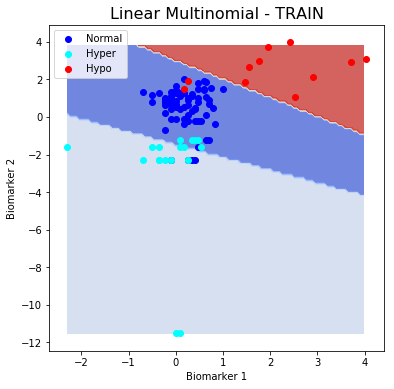

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_decision_boundary(X_train.as_matrix(), y_train.as_matrix(), log_multi, 'Linear Multinomial - TRAIN', ax)
ax.title.set_size(16)

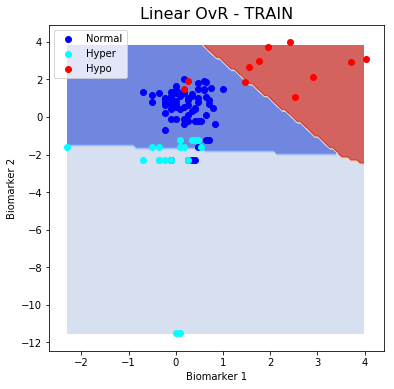

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_decision_boundary(X_train.as_matrix(), y_train.as_matrix(), log_ovr, 'Linear OvR - TRAIN', ax)
ax.title.set_size(16)

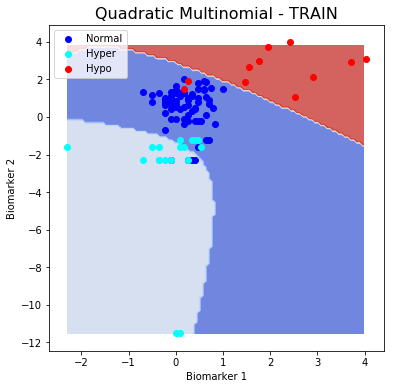

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_decision_boundary(X_train.as_matrix(), y_train.as_matrix(), log_multi_quad, 'Quadratic Multinomial - TRAIN', ax, poly_degree=2)
ax.title.set_size(16)

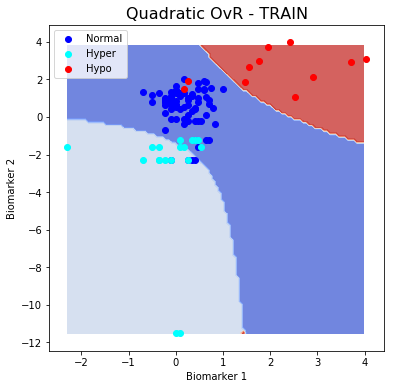

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_decision_boundary(X_train.as_matrix(), y_train.as_matrix(), log_ovr_quad, 'Quadratic OvR - TRAIN', ax, poly_degree=2)
ax.title.set_size(16)

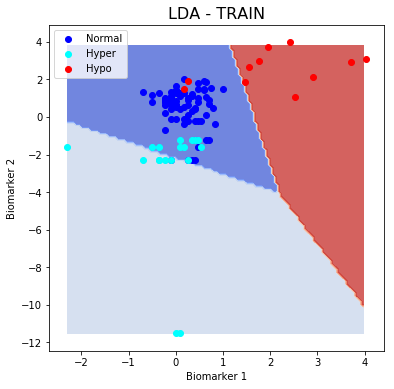

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_decision_boundary(X_train.as_matrix(), y_train.as_matrix(), lda, 'LDA - TRAIN', ax)
ax.title.set_size(16)

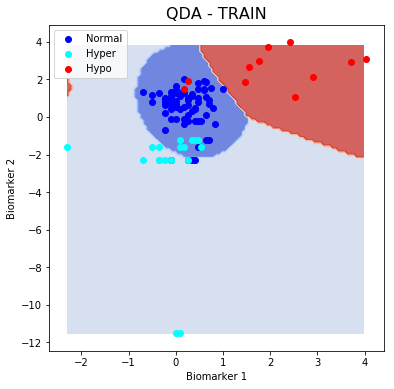

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_decision_boundary(X_train.as_matrix(), y_train.as_matrix(), qda, 'QDA - TRAIN', ax)
ax.title.set_size(16)

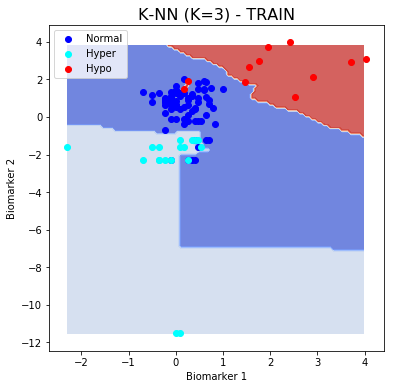

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_decision_boundary(X_train.as_matrix(), y_train.as_matrix(), knn_optimal, 'K-NN (K=3) - TRAIN', ax)
ax.title.set_size(16)

## Answer for Question (2)

Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. 
> **The major difference is that **

>> - **In the OvR model, the boundary of the red region touches the boundary of the cyan region.**
>> - **In the multinomial model, the red and cyan regions are completely separated by the blue region.**

> **The reason is that the OvR models draws 3 separate boundaries, each considering 1 class versus the other 2 classes combined. Thus, the line separating red from (blue + cyan) is steep and intersects with the line separating cyan from (blue + red), resulting in the blue class having a bound on the right (at some larger Biomarker 1 values). On the other hand, the multinomial approach fits classes all at once, and thus the blue region extends to larger Biomarker 1 values without being bounded.  **


Is there a difference between the decision boundaries for the linear logistic regression models and LDA. 
> **The major difference is that**

>> - ** In the LDA model, the regions have relatively more similar areas.**

>> - ** In the linear logistic regression model, region areas are more different.**

> **The reason is that LDA models the predictors as multivariate normal distributions conditioned on the response and draws decision boundaries where the distribution densities intersect. Since LDA assumes that the predictor distributions have the same variance, the resulting regions would have similar areas. On the other hand, linear logistic regression estimates the probability of being in each class using the logit transformation and determine the regions by choosing the class with the highest probability. In this way, there is no guarantee that the area of the class regions should be similar.**

What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.
> **The major difference is that**

>> - ** The quadratic logistic regression has open regions. **

>> - ** The QDA can draw enclosed ovals. **

> **The reason is that quadratic logistic regression simply turns its linear boundaries into 2nd order curves, which opens up. On the other hand, the QDA models predictors as multivariate normal distributions conditioned on the response and draws decision boundaries where the distribution densities intersect. In addition, QDA does not assume equal variance among predictors in different classes. More specifically, the blue class has high prior and low variance while the cyan class has low prior and high variance. The high variance of the cyan class leads to its large area, while the high prior of the blue class results in an oval boundary.**


## Question 3: Fit Decision Trees

We next try out decision trees for thyroid classification. For the following questions, you may use the *Gini* index as the splitting criterion while fitting the decision tree. 
1. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the training and test accuracies as a function of the tree depth. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?

2. Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?

3. Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.

4. Use the `export_graphviz` function in `sklearn` to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain *in words* how the fitted model diagnoses 'hypothyroidism' for a patient.  


*Note:* Look at the `export_graphviz` function in the `sklearn.tree` module. 

You can get a graphic for this visualization by pasting the generated graphviz file in the text box at http://www.webgraphviz.com/ , or you can do it on your own computer.

If you choose the do the latter, you will have to install `GraphViz` and `pydot` to use the decision tree rendering code. For this, you may execute the following commands in a terminal:

`$pip install graphviz`<br>
`$pip install pydot`

*Hint:* You may use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth. You may use the `cross_val_score` function for cross-validation with decision trees.

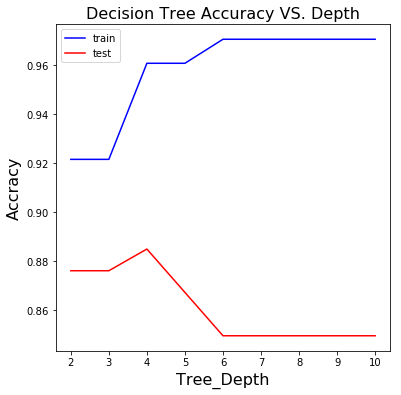

In [19]:
depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
tree_acc_train = []
tree_acc_test = []
for d in depths:
    clf_tree = DecisionTreeClassifier(max_depth=d).fit(X_train, y_train)
    tree_acc_train.append(clf_tree.score(X_train, y_train))
    tree_acc_test.append(clf_tree.score(X_test, y_test))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.plot(depths, tree_acc_train, 'b-', label='train')
ax.plot(depths, tree_acc_test, 'r-', label='test')
ax.set_xlabel('Tree_Depth', fontsize=16)
ax.set_ylabel('Accracy', fontsize=16)
ax.set_title('Decision Tree Accuracy VS. Depth', fontsize=16)
ax.legend()

In [20]:
# training and test accuracies at depth = 6
print('Depth = 6')
print('train_acc: {}'.format(tree_acc_train[4]))
print('test_acc: {}\n'.format(tree_acc_test[4]))

# training and test accuracies at depth = 4
print('Depth = 4')
print('train_acc: {}'.format(tree_acc_train[2]))
print('test_acc: {}'.format(tree_acc_test[2]))

Depth = 6
train_acc: 0.9705882352941176
test_acc: 0.8495575221238938

Depth = 4
train_acc: 0.9607843137254902
test_acc: 0.8849557522123894


In [21]:
cv_scores_tree = []

for d in depths:
    tree = DecisionTreeClassifier(max_depth=d)
    scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_tree.append(scores.mean())

optimal_depth = depths[cv_scores_tree.index(max(cv_scores_tree))]
tree_optimal = DecisionTreeClassifier(max_depth=optimal_depth).fit(X_train, y_train)
print('=============================')
print('Decision Tree\n')
print('Optimal Depth = {}'.format(optimal_depth))
print('train_acc = {}\ntest_acc = {}\n'.format(tree_optimal.score(X_train, y_train), tree_optimal.score(X_test, y_test)))

Decision Tree

Optimal Depth = 2
train_acc = 0.9215686274509803
test_acc = 0.8761061946902655



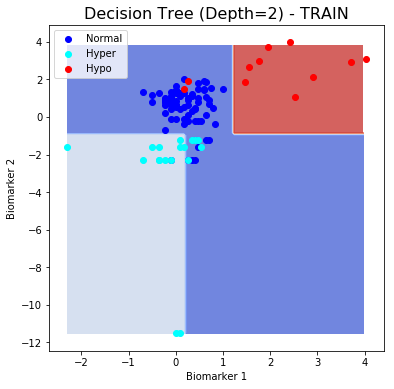

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_decision_boundary(X_train.as_matrix(), y_train.as_matrix(), tree_optimal, 'Decision Tree (Depth=2) - TRAIN', ax)
ax.title.set_size(16)

In [23]:
export_graphviz(tree_optimal, out_file='tree_optimal.dot')

![decision_tree](tree_vis.png)

## Answer for Question (3)

Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?

> ** Yes, at tree depth >= 6, the fitted decision tree model achieves near-perfect classification on the training set (train_acc = 0.970588). The corresponding test accuracy is 0.849558, which is not the optimal achievable test accuracy based on the graph. The best TEST accuracy according to the graph occurs at depth = 4 with accuracy = 0.884956. This suggests that the model with depth >= 6 has overfitted on the training data, resulting in a worse test accuracy compared to a model that has not overfitted.**

Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?

> ** The cross-validated decision tree model has an optimal depth of 2. The training accuracy = 0.9215686274509803 and the test accuracy = 0.8761061946902655. Comparing the performance of the decision tree (depth=2) model with other models, we rank the models by their test accuracies as follows:**

>> ** Quadratic Multinomial > Linear Multinomial > Quadratic OvR = Decision Tree (Depth=2) > K-NN (K=3) > QDA  > Linear OvR > LDA **

How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.

> ** The decision boundaries of the decision tree model are either vertical or horizontal lines whereas other models draw sloped lines and/or higher order curves. This is explained by how decision trees are trained, which is by asking whether a certain feature is greater than or less than some value at a decision node (1 feature per split, greedily). By doing so, we are effectively drawing vertical or horizontal lines dividing the greater than portion and the less than portion, resulting in decision boundaries that are either vertical or horizontal. However, other models are fitted on the whole set of predictors, resulting in sloped lines or higher order curves as boundaries.**

Use the `export_graphviz` function in `sklearn` to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain *in words* how the fitted model diagnoses 'hypothyroidism' for a patient.  

> ** The fitted model diagnoses 'hypothyroidism' (red) for a patient if the patient's biomarker 2 > -0.9485 and the patient's biomarker 1 > 1.2259**

## Question 4: Too many models to choose from!

We have so far seen six different ways of fitting a classification model for thyroid classification problem: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **k-NN** and **decision tree**. Which of these methods should one use in practice? To answer this question, we now look at the pros and cons of each method.

1. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Ease of interpretability

2. If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? 

##  Answer to Question (4)

Compare and contrast the six models

> **See summary in the following table:**
> - p: # of predictors
> - n: # of observations
> - k: # of classes

Classifier| Classification Performance| Complexity of Decision Boundary | Memory Storage | Ease of Interpretability
----------|---------------------------|--------------------------------|----------------|--------------------------
Linear logistic regression| 0.885 (rank 2) |Linear (rank 1 least complicated)| $O(p)$ (rank 1 least memory) | rank 4
Logistic regression w/ poly terms| 0.894 (rank 1 highest test_acc) |Curves (rank 4) | $O(p^2)$ (rank 2) | rank 5
LDA| 0.832 (rank 6) |Linear (rank 1)| $O(p^2+k)$ (rank 4) | rank 2
QDA| 0.850 (rank 5) |Curves (rank 4) | $O(kp^2+k)$ (rank 5) | rank 3
K-NN| 0.867 (rank 3) | Arbitrarily complicated (rank 6) | $O(np)$ (rank 6) |rank 6
Decision Tree| 0.876 (rank 3) | Axis-aligned partition of feature space (rank 3)| $O(2^{depth})$ (rank 3 if depth is moderate) | rank 1 easiest


> **Note: For memory storage, non-parametric methods such as K-NN and Decision Tree typically requires more memory storage than parametric methods such as linear logistic regression and discriminant analysis. However, for our case of decision tree with only depth=2, the memory storage requirement is low.**


If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? 

> ** We would be most comfortable in using the Decision Tree model (depth = 2), because it has **
> - ** relatively high performance **
> - ** highest ease of interpretability **
    >> ** readable from axies alined boundaries; each axis corresponds with a feature**
> - ** relatively low complexity of decision boundaries **
    >> ** axis-aligned partitions **
> - ** relatively low memory storage requirement **
    >> ** with a reasonable depth, just need to store the decision nodes and the associated boundary values **

## Question 5: Including an 'abstain' option

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction, whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost. How does one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

1. More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model from Question 1, Part 3? Note that this needs to be evaluated on the patients in the test set. Your task is to design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient.   Give a justification for your approach.

2. **Presentation:** Prepare a set of 5 slides explaining your approach to the hospital management. Your presentation must be accessible to the lay man. Explain in particular how your approach would be robust to changes in the costs of using the abstain option.

*Hint:* think of a way to use the estimated probabilities from the logistic regression model to decide who to classify as *abstain*.

In [24]:
# Loss of log_OVR without abstain (t=0)
model = log_ovr
model_name = 'OvR Logistic Regression'
print('========================')
print('NO abstain')
print('------------------------')
print(model_name, '\n')

loss_avg = ((1-log_ovr.score(X_test, y_test)) * len(y_test) * 5000)/len(y_test)
print('Avg-loss per patient on TEST set = {}'.format(loss_avg))

NO abstain
------------------------
OvR Logistic Regression 

Avg-loss per patient on TEST set = 796.4601769911505


### Q(5) Approach: Abstain if the predicted class k has its predicted probability smaller than its threshold 

> $k = max(y_{proba}[i]) + 1$

> $max(y_{proba}[i]) \leq t_k$


In [25]:
def get_optimal_t_3Thresholds(yi_proba, yi_true, abstain_c=1000, mis_pred_c=5000, print_op=True):
    t_lin = np.linspace(0, 1, 501)
    losses = []
    M, N = yi_proba.shape
    for t in t_lin:
        loss = 0
        abs_loss = 0
        mis_loss = 0
        for i in range(M):
            yi_hat = np.argmax(yi_proba[i]) + 1 # class label correct from 0-indexing
            max_p = max(yi_proba[i])
            if max_p <= t: # abstained
                loss += abstain_c
            else: # NOT abstained
                if yi_hat != yi_true[i]: # mis-classified
                    loss += mis_pred_c
        
        losses.append(loss)
    
    optimal_idx = np.argmin(losses)
    min_loss = losses[optimal_idx]
    ii = optimal_idx
    while losses[ii] == min_loss:
        ii += 1
    optimal_idx = int((optimal_idx + ii - 1)/2)
    
    if print_op:
        print('Class {}: optimal_t = {}'.format(int(yi_true[0]), t_lin[optimal_idx]))

    return t_lin[optimal_idx]

def decide_abstain_mis_3Thresholds(y_proba, y_true, t1, t2, t3):
    M, N = y_proba.shape
    y_abstain = np.zeros((M,)) # abstained
    y_mis = np.zeros((M,)) # NOT abstained and mis-classified
    for i in range(M):
        y_hat = np.argmax(y_proba[i]) + 1 # class label correct from 0-indexing
        max_p = max(y_proba[i])
        
        if y_hat == 1:
            t = t1
        elif y_hat == 2:
            t = t2
        else:
            t = t3
        
        if max_p <= t: # class_i probability is smaller than ti
            y_abstain[i] = 1 # abstained
        else: # NOT abstained
            if y_hat != y_true[i]: 
                y_mis[i] = 1 # mis-classified
    
    return y_abstain, y_mis

# avg_loss = (mis_prediction_cost + abstain_cost)/ n_observations
def get_avg_loss(y_abstain, y_mis, abstain_c=1000, mis_pred_c=5000):
    return (sum(y_mis == 1)*mis_pred_c + sum(y_abstain == 1)*abstain_c)/len(y_abstain)

In [26]:
model = log_ovr
model_name = 'OvR Logistic Regression'
y_pred = model.predict(X_train)

print('========================')
print('Metric: 3 Thresholds')
print('------------------------')
print(model_name, '\n')

t = []
for i in range(3):
    label = i+1
    yi_proba = model.predict_proba(X_train)[y_pred == label]
    yi_true = y_train[y_pred == label]
    t.append(get_optimal_t_3Thresholds(yi_proba, yi_true.as_matrix()))

y_abstain_train, y_mis_train = decide_abstain_mis_3Thresholds(model.predict_proba(X_train), y_train.as_matrix(), t[0], t[1], t[2])
y_abstain_test, y_mis_test = decide_abstain_mis_3Thresholds(model.predict_proba(X_test), y_test.as_matrix(), t[0], t[1], t[2])

print('\nAvg-loss per patient on TRAIN set = {}'.format(get_avg_loss(y_abstain_train, y_mis_train)))
print('Avg-loss per patient on TEST set = {}'.format(get_avg_loss(y_abstain_test, y_mis_test)))

Metric: 3 Thresholds
------------------------
OvR Logistic Regression 

Class 1: optimal_t = 0.6880000000000001
Class 2: optimal_t = 0.812
Class 3: optimal_t = 0.274

Avg-loss per patient on TRAIN set = 323.52941176470586
Avg-loss per patient on TEST set = 477.87610619469024


In [27]:
model = log_ovr
model_name = 'OvR Logistic Regression'
y_pred = model.predict(X_train)

cost_step = 500
n_cost = 20
abstain_costs = [100 + i * cost_step for i in np.arange(n_cost)]
mis_pred_costs = [100 + i * cost_step for i in np.arange(n_cost)]

abstain_rates_ac = []
mis_pred_rates_ac = []
for ac in abstain_costs:
    y_pred = model.predict(X_train)
    t = []
    for i in range(3):
        label = i+1
        yi_proba = model.predict_proba(X_train)[y_pred == label]
        yi_true = y_train[y_pred == label]
        t.append(get_optimal_t_3Thresholds(yi_proba, yi_true.as_matrix(), abstain_c = ac, mis_pred_c=5000, print_op=False))
    
    #y_abstain_train, y_mis_train = decide_abstain_mis_3Thresholds(model.predict_proba(X_train), y_train.as_matrix(), t[0], t[1], t[2])
    
    y_abstain_test, y_mis_test = decide_abstain_mis_3Thresholds(model.predict_proba(X_test), y_test.as_matrix(), t[0], t[1], t[2])
    abstain_rates_ac.append(np.mean(y_abstain_test))
    mis_pred_rates_ac.append(np.mean(y_mis_test))

abstain_rates_mpc = []
mis_pred_rates_mpc = []
for mpc in mis_pred_costs:
    y_pred = model.predict(X_train)
    t = []
    for i in range(3):
        label = i+1
        yi_proba = model.predict_proba(X_train)[y_pred == label]
        yi_true = y_train[y_pred == label]
        t.append(get_optimal_t_3Thresholds(yi_proba, yi_true.as_matrix(), abstain_c=1000, mis_pred_c = mpc, print_op=False))
    
    #y_abstain_train, y_mis_train = decide_abstain_mis_3Thresholds(model.predict_proba(X_train), y_train.as_matrix(), t[0], t[1], t[2])
    
    y_abstain_test, y_mis_test = decide_abstain_mis_3Thresholds(model.predict_proba(X_test), y_test.as_matrix(), t[0], t[1], t[2])
    abstain_rates_mpc.append(np.mean(y_abstain_test))
    mis_pred_rates_mpc.append(np.mean(y_mis_test))

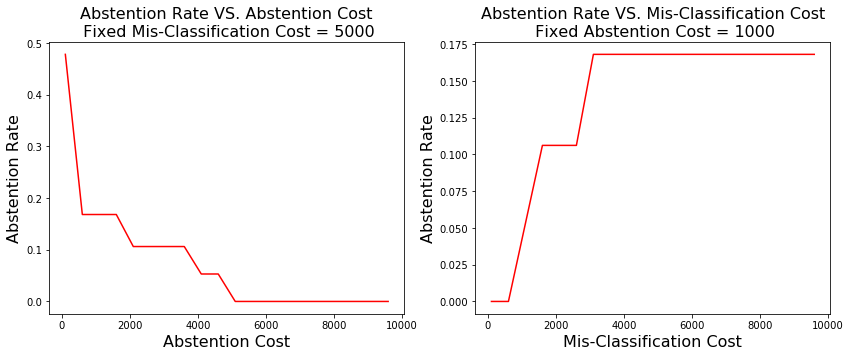

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))
ax[0].plot(abstain_costs, abstain_rates_ac, 'r-', label='abstain_rate')
# ax[0].plot(abstain_costs, mis_pred_rates_ac, 'b-', label='mis_pred_rate')
ax[0].set_title('Abstention Rate VS. Abstention Cost\n Fixed Mis-Classification Cost = 5000', fontsize=16)
ax[0].set_xlabel('Abstention Cost', fontsize=16)
ax[0].set_ylabel('Abstention Rate', fontsize=16)
# ax[0].legend()

ax[1].plot(mis_pred_costs, abstain_rates_mpc, 'r-', label='abstain_rate')
# ax[1].plot(mis_pred_costs, mis_pred_rates_mpc, 'b-', label='mis_pred_rate')
ax[1].set_title('Abstention Rate VS. Mis-Classification Cost\n Fixed Abstention Cost = 1000', fontsize=16)
ax[1].set_xlabel('Mis-Classification Cost', fontsize=16)
ax[1].set_ylabel('Abstention Rate', fontsize=16)
# ax[1].legend()

##  Answer to Question (5)

How does one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

1. More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model from Question 1, Part 3? Note that this needs to be evaluated on the patients in the test set. Your task is to design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient.  Give a justification for your approach.

2. **Presentation:** Prepare a set of 5 slides explaining your approach to the hospital management. Your presentation must be accessible to the lay man. Explain in particular how your approach would be robust to changes in the costs of using the abstain option.


> - ** Idea: **

>> ** total cost = abstention cost + mis-classification cost **

>> ** If all predictions are abstained, the total cost would be dominated by abstention; if nothing abstained, the total cost would be dominated by mis-classifications. Therefore, we designed a model which can find the optimal abstention rate to minimize the total cost. **

> - ** Approach: **

>> ** For a single classification output, we estimate the probability associated with the class from the model. If this probability is higher than the class's credibility threshold, we decide it NOT to be abstained. Otherwise, we would change the output class to be ABSTAINED.**

>> ** The credibility thresholds of the all classes are found on the TRAINING set. For each class, by looping through all possible thresholds in `np.linspace(0, 1, 501)`, we calculate and record the current total cost using this threshold given the unit cost of abstention and mis-classification. The optimal threshold is the one that gives the minimum total cost. **

>> ** With the credibility thresholds (t1, t2, t3 in this case), we evaluate the total cost of the fitted model on the TEST set. **


> - ** Benchmark: **

>> ** Without Abstention:**

>> ** Average cost per patient on TEST set for the OvR logistic regression model is 796.4601769911505.**

> - **Result: **

>> ** With Abstention based on the optimal thresholds of the 3 classes found on TRAIN set: **

>> - ** Class 1: t = 0.688 **

>> - ** Class 2: t = 0.812 **

>> - ** Class 3: t = 0.274 **

>> ** Average cost per patient on TEST set for the OvR logistic regression model is 477.87610619469024.**

> - **Robustness: **

>> ** As shown in the above plot of *Abstention Rates VS. Costs*, we can see: **

>> - ** from *left* plot: Given a mis-classification cost, our model's abstention rate decreases as the abstention cost increases**

>> - ** form *right* plot: Given a abstention cost, our model's abstention rate increases as the mis-classification cost increases**

>> **This intuitively demonstrate our model's robustness that the total cost would be minimized if either of the following is true:**

>> - ** Abstain less when the abstention cost is relatively higher than the mis-classification cost. **

>> - ** Abstain more when the mis-classification cost is relatively higher than the abstention cost. **


---
### Supplementary Approach 1: 

### Abstain if abs[max($y_{proba}[i]$) - min($y_{proba}[i]$)] is smaller than a given threshold

In [29]:
# Decide to abstain if abs(max(y_proba[i])-min(y_proba[i])) is smaller than a given threshold t
def decide_abstain_mis_t_MaxDiff(y_proba, y_true, t):
    M, N = y_proba.shape
    y_abstain = np.zeros((M,)) # abstained
    y_mis = np.zeros((M,)) # NOT abstained and mis-classified
    for i in range(M):
        y_hat = np.argmax(y_proba[i]) + 1 # class label correct from 0-indexing
        
        sorted_probas = np.sort(y_proba[i])
        min_p = sorted_probas[0]
        max_p = sorted_probas[-1]
        diff_proba = max_p - min_p
        
        if diff_proba <= t: # Diff. of max_p and min_pis is smaller than t
            y_abstain[i] = 1 # abstained
        
        else: # NOT abstained
            if y_hat != y_true[i]: 
                y_mis[i] = 1 # mis-classified
    
    return y_abstain, y_mis

In [30]:
def get_t_MaxDiff(model, X, y,  poly_deg=0):
    avg_losses = []
    t_lin = np.linspace(0, 1, 501)
    for t in t_lin:
        if poly_deg != 0: # transform to polynomial features
            XX = PolynomialFeatures(poly_deg).fit_transform(X)
            y_abstain, y_mis = decide_abstain_mis_t_MaxDiff(model.predict_proba(XX), y.as_matrix(), t)
        else:
            y_abstain, y_mis = decide_abstain_mis_t_MaxDiff(model.predict_proba(X), y.as_matrix(), t)
        avg_losses.append(get_avg_loss(y_abstain, y_mis))
    
    optimal_idx = np.argmin(avg_losses)
    return t_lin[optimal_idx], avg_losses[optimal_idx]
    

In [31]:
model = log_ovr
model_name = 'OvR Logistic Regression'
print('========================')
print('Metric: MaxDiff Threshold')
print('------------------------')
print(model_name, '\n')

t_train, loss_train = get_t_MaxDiff(model, X_train, y_train)
print('Min(Avg-loss) per patient on TRAIN set = {}, achieved at t = {}'.format(t_train, loss_train))
y_abstain_test, y_mis_test = decide_abstain_mis_t_MaxDiff(model.predict_proba(X_test), y_test.as_matrix(), t_train)
print('Avg-loss per patient on TEST set = {}'.format(get_avg_loss(y_abstain_test, y_mis_test)))

Metric: MaxDiff Threshold
------------------------
OvR Logistic Regression 

Min(Avg-loss) per patient on TRAIN set = 0.68, achieved at t = 362.7450980392157
Avg-loss per patient on TEST set = 575.2212389380531


---
### Supplementary Approach 2: 

### Abstain if max($y_{proba}[i]$) is smaller than a given threshold

In [32]:
# Decide to abstain if abs(max(y_proba[i])-min(y_proba[i])) is smaller than a given threshold t
def decide_abstain_mis_t_MaxMax(y_proba, y_true, t):
    M, N = y_proba.shape
    y_abstain = np.zeros((M,)) # abstained
    y_mis = np.zeros((M,)) # NOT abstained and mis-classified
    for i in range(M):
        y_hat = np.argmax(y_proba[i]) + 1 # class label correct from 0-indexing
        
        sorted_probas = np.sort(y_proba[i])
        max_p = sorted_probas[-1]
        
        if max_p <= t: # max_p is smaller than threshold t
            y_abstain[i] = 1 # abstained
        
        else: # NOT abstained
            if y_hat != y_true[i]: 
                y_mis[i] = 1 # mis-classified
    
    return y_abstain, y_mis

In [33]:
def get_t_MaxMax(model, X, y,  poly_deg=0):
    avg_losses = []
    t_lin = np.linspace(0, 1, 501)
    for t in t_lin:
        if poly_deg != 0: # transform to polynomial features
            XX = PolynomialFeatures(poly_deg).fit_transform(X)
            y_abstain, y_mis = decide_abstain_mis_t_MaxMax(model.predict_proba(XX), y.as_matrix(), t)
        else:
            y_abstain, y_mis = decide_abstain_mis_t_MaxMax(model.predict_proba(X), y.as_matrix(), t)
        avg_losses.append(get_avg_loss(y_abstain, y_mis))
    
    optimal_idx = np.argmin(avg_losses)
    return t_lin[optimal_idx], avg_losses[optimal_idx]
    

In [34]:
model = log_ovr
model_name = 'OvR Logistic Regression'
print('========================')
print('Metric: MaxMax Threshold')
print('------------------------')
print(model_name, '\n')

t_train, loss_train = get_t_MaxDiff(model, X_train, y_train)
print('Min(Avg-loss) per patient on TRAIN set = {}, achieved at t = {}'.format(t_train, loss_train))
y_abstain_test, y_mis_test = decide_abstain_mis_t_MaxMax(model.predict_proba(X_test), y_test.as_matrix(), t_train)
print('Avg-loss per patient on TEST set = {}'.format(get_avg_loss(y_abstain_test, y_mis_test)))

Metric: MaxMax Threshold
------------------------
OvR Logistic Regression 

Min(Avg-loss) per patient on TRAIN set = 0.68, achieved at t = 362.7450980392157
Avg-loss per patient on TEST set = 575.2212389380531
